### Import libraries

In [2]:
import sys
sys.path.append("..")
from model import classic_model, losses, grapher
from data import data_generation, batch_creator, gp_kernels, gp_priors
from helpers import helpers, plotter
from keras.callbacks import ModelCheckpoint
from inference import infer
import tensorflow as tf; import keras
import time

/Users/omernivron/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
save_dir = '/Users/omernivron/Downloads/GPT'

In [4]:
pad_pos_tr, pad_pos_te, pad_y_fren_tr, pad_y_fren_te, _, df_te = data_generation.data_generator_for_gp_mimick_gpt(150, ordered = False)

In [11]:
train_step, test_step, loss_object, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [6]:
batch_pos_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_pos_tr, pad_y_fren_tr, batch_s=1)
batch_pos_tr1 = batch_pos_tr[:, :-1]
batch_pos_tr_current = batch_pos_tr[:, 1:]

In [7]:
# batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=1)
# batch_pos_tr1 = batch_pos_tr[:, :-1]
# batch_pos_tr_current = batch_pos_tr[:, 1:]

Already exists
Restored from /Users/omernivron/Downloads/GPT/ckpt/check_1/ckpt-52
Tensor("truediv_1:0", shape=(), dtype=float64)
Tensor("truediv_1:0", shape=(), dtype=float64)


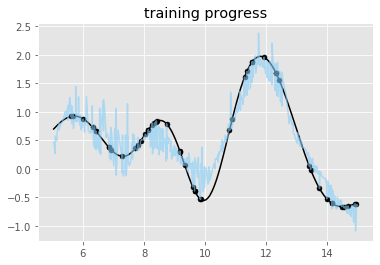

Tensor("truediv_1:0", shape=(), dtype=float64)
Epoch 0 batch 0 train Loss -0.2759 test Loss 61378.3229 with training MSE metric 0.0615 and testing MSE metric 12172.4385
Time taken for 1 epoch: 48.8251268863678 secs



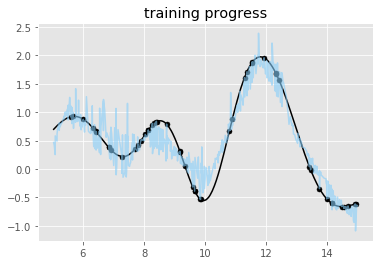

Epoch 1 batch 0 train Loss -0.2740 test Loss 48822.6498 with training MSE metric 0.0620 and testing MSE metric 12677.3838
Time taken for 1 epoch: 46.45075702667236 secs



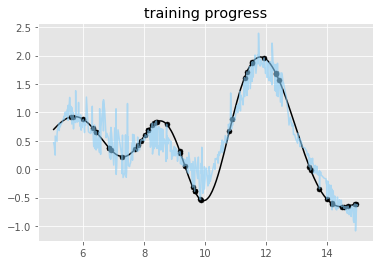

Epoch 2 batch 0 train Loss -0.2768 test Loss 42658.8835 with training MSE metric 0.0613 and testing MSE metric 13195.8730
Time taken for 1 epoch: 46.497167110443115 secs



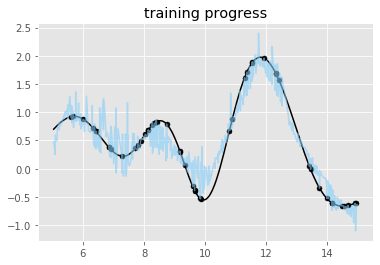

Epoch 3 batch 0 train Loss -0.2817 test Loss 49210.4297 with training MSE metric 0.0601 and testing MSE metric 13633.3174
Time taken for 1 epoch: 46.47799873352051 secs



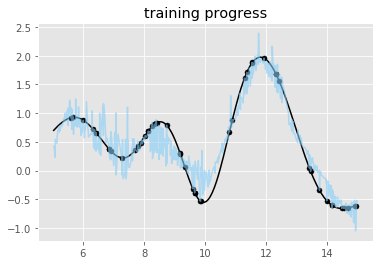

Epoch 4 batch 0 train Loss -0.2853 test Loss 46391.9550 with training MSE metric 0.0592 and testing MSE metric 14091.6680
Time taken for 1 epoch: 46.966766119003296 secs



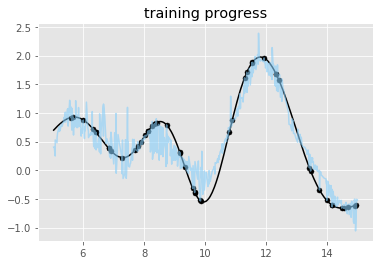

Epoch 5 batch 0 train Loss -0.2903 test Loss 45779.4048 with training MSE metric 0.0581 and testing MSE metric 14498.2051
Time taken for 1 epoch: 46.89885592460632 secs



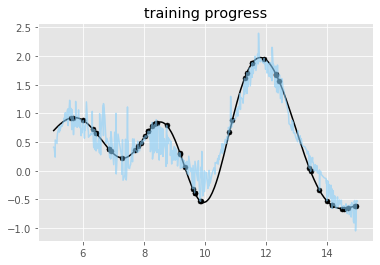

Epoch 6 batch 0 train Loss -0.2879 test Loss 39293.3863 with training MSE metric 0.0587 and testing MSE metric 14967.4229
Time taken for 1 epoch: 47.023768186569214 secs



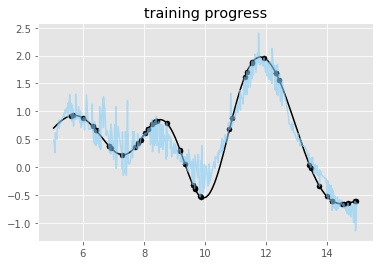

Epoch 7 batch 0 train Loss -0.2910 test Loss 38999.2016 with training MSE metric 0.0579 and testing MSE metric 15428.5791
Time taken for 1 epoch: 47.50064516067505 secs



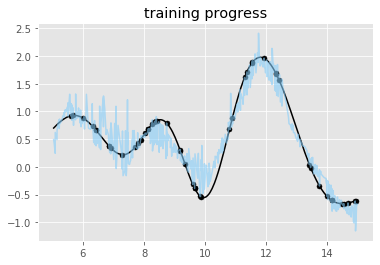

Epoch 8 batch 0 train Loss -0.2861 test Loss 38946.4519 with training MSE metric 0.0590 and testing MSE metric 15944.6836
Time taken for 1 epoch: 47.088682889938354 secs



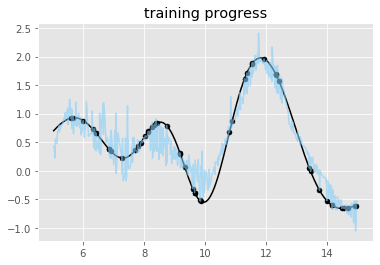

Epoch 9 batch 0 train Loss -0.2914 test Loss 36054.1538 with training MSE metric 0.0578 and testing MSE metric 16478.8516
Time taken for 1 epoch: 47.08771300315857 secs



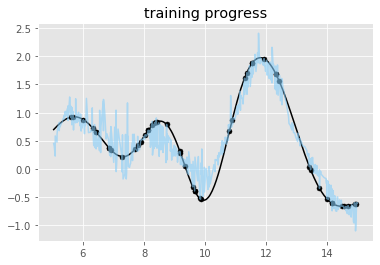

Epoch 10 batch 0 train Loss -0.2936 test Loss 38783.3146 with training MSE metric 0.0573 and testing MSE metric 16970.8867
Time taken for 1 epoch: 47.36506175994873 secs



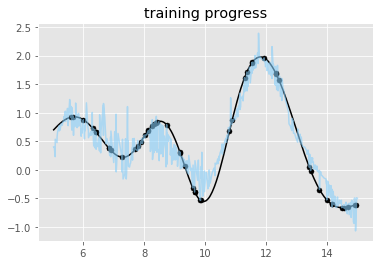

Epoch 11 batch 0 train Loss -0.3002 test Loss 38451.5119 with training MSE metric 0.0559 and testing MSE metric 17481.3418
Time taken for 1 epoch: 46.99357891082764 secs



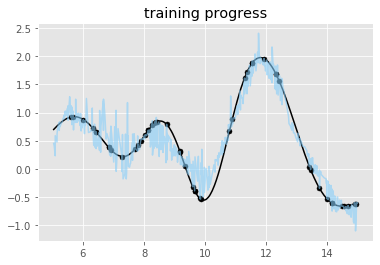

Epoch 12 batch 0 train Loss -0.2967 test Loss 37488.8781 with training MSE metric 0.0566 and testing MSE metric 17970.4434
Time taken for 1 epoch: 47.28997206687927 secs



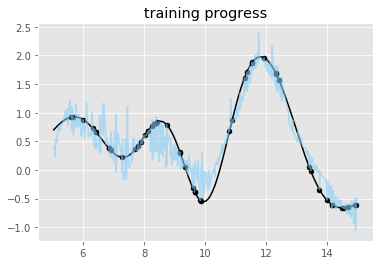

Epoch 13 batch 0 train Loss -0.3017 test Loss 39788.0483 with training MSE metric 0.0555 and testing MSE metric 18472.3867
Time taken for 1 epoch: 47.21885108947754 secs



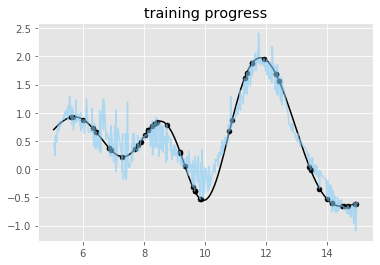

Epoch 14 batch 0 train Loss -0.2956 test Loss 39963.1169 with training MSE metric 0.0569 and testing MSE metric 18955.7559
Time taken for 1 epoch: 47.78324818611145 secs



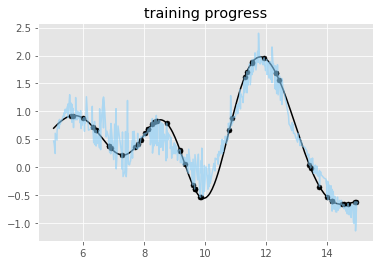

Epoch 15 batch 0 train Loss -0.3016 test Loss 41151.9201 with training MSE metric 0.0555 and testing MSE metric 19436.2598
Time taken for 1 epoch: 47.560791015625 secs



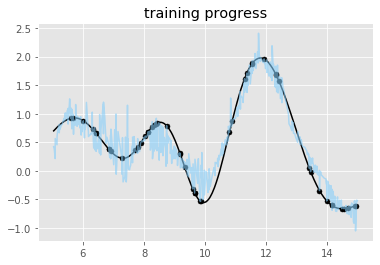

Epoch 16 batch 0 train Loss -0.2974 test Loss 40532.7556 with training MSE metric 0.0565 and testing MSE metric 19940.9316
Time taken for 1 epoch: 47.85472631454468 secs



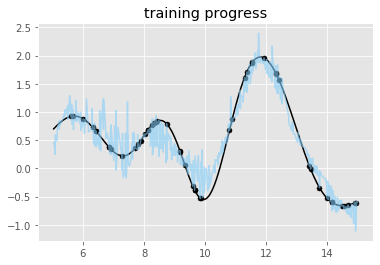

Epoch 17 batch 0 train Loss -0.3059 test Loss 49762.9608 with training MSE metric 0.0546 and testing MSE metric 20431.1660
Time taken for 1 epoch: 47.729186058044434 secs



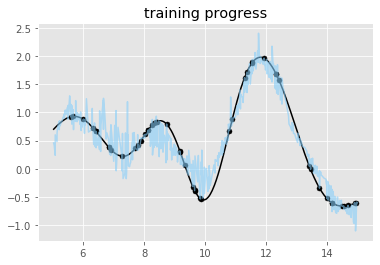

Epoch 18 batch 0 train Loss -0.3031 test Loss 50374.0594 with training MSE metric 0.0552 and testing MSE metric 20921.2207
Time taken for 1 epoch: 47.91035509109497 secs



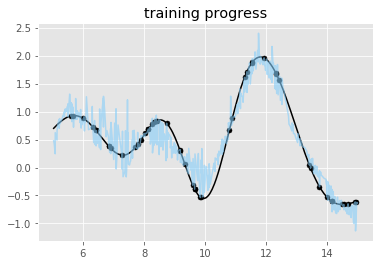

Epoch 19 batch 0 train Loss -0.3017 test Loss 48294.6766 with training MSE metric 0.0555 and testing MSE metric 21391.7422
Time taken for 1 epoch: 47.574230909347534 secs



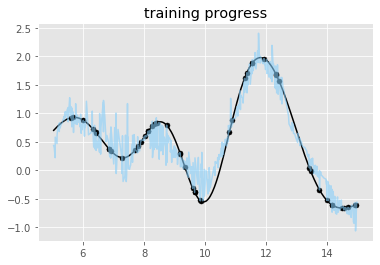

Epoch 20 batch 0 train Loss -0.2999 test Loss 46917.7284 with training MSE metric 0.0559 and testing MSE metric 21887.3184
Time taken for 1 epoch: 48.051743030548096 secs



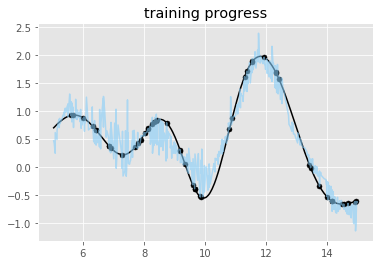

Epoch 21 batch 0 train Loss -0.3079 test Loss 56842.6288 with training MSE metric 0.0542 and testing MSE metric 22319.1055
Time taken for 1 epoch: 47.681528091430664 secs



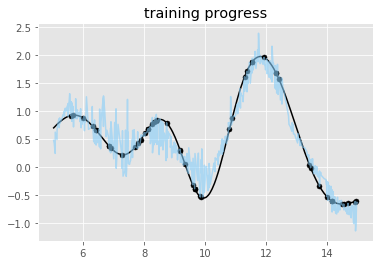

Epoch 22 batch 0 train Loss -0.3049 test Loss 54793.1924 with training MSE metric 0.0548 and testing MSE metric 22763.7520
Time taken for 1 epoch: 47.493589878082275 secs



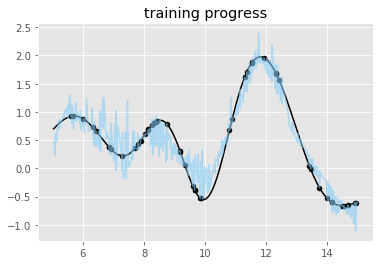

Epoch 23 batch 0 train Loss -0.3049 test Loss 55144.4522 with training MSE metric 0.0548 and testing MSE metric 23219.7129
Time taken for 1 epoch: 47.322773933410645 secs



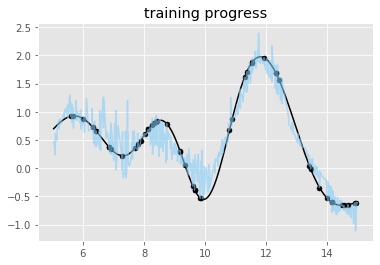

Epoch 24 batch 0 train Loss -0.3061 test Loss 58212.8025 with training MSE metric 0.0546 and testing MSE metric 23667.9805
Time taken for 1 epoch: 47.148356914520264 secs



In [12]:
if __name__ == '__main__':
    writer = tf.summary.create_file_writer(save_dir + '/logs/')
    optimizer_c = tf.keras.optimizers.RMSprop()
    decoder = classic_model.Decoder(32); tf.random.set_seed(443)   
    EPOCHS = 25; batch_s  = 64; run = 1; step = 0
#     num_batches = int(pad_y_fren_tr.shape[0] / batch_s)
    num_batches = 1500
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer = optimizer_c, net = decoder)
    main_folder = "/Users/omernivron/Downloads/GPT/ckpt/check_"
    folder = main_folder + str(run); helpers.mkdir(folder)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    
    with writer.as_default():
        for epoch in range(EPOCHS):

            start = time.time()

            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                m_te.reset_states(); test_loss.reset_states()
#                 batch_pos_tr, batch_tar_tr, _ = batch_creator.create_batch_gp_mim_2(pad_pos_tr, pad_y_fren_tr, batch_s=64)
#                 batch_pos_tr1 = batch_pos_tr[:, :-1]
#                 batch_pos_tr_current = batch_pos_tr[:, 1:]
                pred, pred_log = train_step(decoder, optimizer_c, train_loss, m_tr, batch_pos_tr1, batch_pos_tr_current, batch_tar_tr)
                
                if batch_n % 1500 == 0:
                    plotter.sample_plot_w_training(batch_pos_tr_current[1, :], batch_tar_tr[1, 1:], pred[1, :], title = 'training progress')

#                     batch_pos_te, batch_tar_te, _ = batch_creator.create_batch_gp_mim_2(pad_pos_te, pad_y_fren_te, batch_s=64)
                    pos_te1 = pad_pos_te[:, :-1]
                    pos_te_current = pad_pos_te[:, 1:]
                    pred_te, pred_log_te = test_step(decoder, test_loss, m_te, pos_te1, pos_te_current, pad_y_fren_te)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)

            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))